In [1]:
# Import dependencies
import matplotlib
import os
import numpy as np
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, Binary, quicksum, Integer
from dwave.system import LeapHybridCQMSampler
import itertools
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
from dotenv import load_dotenv, find_dotenv

from model_builder import build_cqm
from pattern_generator import generate_patterns

In [2]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [3]:
def solve(cqm, time_limit=5):

  """
    Solve the Constrained Quadratic Model (CQM) using the LeapHybridCQMSampler.

    Args:
        cqm (ConstrainedQuadraticModel): The Constrained Quadratic Model to solve.
        time_limit (int): Time limit in seconds for the solver.

    Returns:
        sampleset (SampleSet): The resulting sampleset from the solver.
    """

  sampler = LeapHybridCQMSampler(token=token)
  print("Submitting CQM to solver {}.".format(sampler.solver.name))
  sampleset = sampler.sample_cqm(cqm, label='Cutting stock problem 1D', time_limit=time_limit)
  return sampleset

In [4]:
def parse_solution(sampleset):

  """
    Parse the solution from the sampleset obtained from the solver.

    Args:
        sampleset (SampleSet): The sampleset obtained from the solver.

    Returns:
        energy (float): The energy of the best solution.
        non_zero_values (dict): Dictionary of non-zero values in the best solution.
    Raises:
        ValueError: If no feasible solution is found in the sampleset.
    """

  feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
  if not len(feasible_sampleset):
    raise ValueError("No feasible solution found")
  
  solution = feasible_sampleset.first.sample
  non_zero_values = {key: int(value) for key, value in solution.items() if value != 0}
  energy = feasible_sampleset.first.energy
  
  return energy, non_zero_values

In [5]:
def print_solution(solution):

    """
    Print the optimized cutting scheme based on the provided solution.

    Args:
        solution (dict): The solution dictionary containing the cutting patterns and values.
    """
    
    # Initialize totals dictionary with string keys
    totals = {str(width): 0 for width in order_widths}  
    for key in solution:
        pattern_widths = key.strip('x()').split(', ')
        for width in pattern_widths:
            width = width.strip()
            if width in totals:
                totals[width] += int(solution[key])

    formatted_totals = {
        f"{width}": total
        for width, total in totals.items()
    }

    # Print the total number of rolls
    print(f'Total number of rolls to use {int(energy)} \n')

    print("{:<15} {:<15} {:<15}".format("Order Width", "Demand", "Rolls to cut"))
    for initial_width, total in zip(order_widths, demand):
        optimized_width = formatted_totals[str(initial_width)]
        print("{:<15} {:<15} {:<15}".format(initial_width, total, optimized_width))

    patterns = list(solution.keys())
    values = list(solution.values())

    # Sort patterns and values in ascending order of values
    sorted_indices = np.argsort(values)
    sorted_patterns = [patterns[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]

    plt.figure(figsize=(12, 10))
    bars = plt.barh(sorted_patterns, [roll_width] * len(sorted_patterns), align='center', color='lightgray', alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('')
    plt.title('Cutting Scheme')

    # Add value labels to the bars
    for bar, pattern, value in zip(bars, sorted_patterns, sorted_values):
        positions = [int(pos) for pos in pattern.strip('x()').split(', ')]
        cum_sum = np.cumsum(positions)
        for i, pos in enumerate(cum_sum):
            if i == 0:
                plt.text(pos / 2, bar.get_y() + bar.get_height() / 2, str(positions[i]),
                        ha='center', va='center')
            else:
                plt.text((pos + cum_sum[i - 1]) / 2, bar.get_y() + bar.get_height() / 2, str(positions[i]),
                        ha='center', va='center')

        plt.text(0, bar.get_y() + bar.get_height() / 2, str(value),
                ha='right', va='center', color='black', fontweight='bold', fontsize=10)


    # Set x-axis ticks and limit
    plt.xticks(order_widths + [roll_width])
    plt.xlim(0, roll_width)

    # Calculate and draw dashed lines for cut positions
    for pattern in sorted_patterns:
        positions = [int(pos) for pos in pattern.strip('x()').split(', ')]
        cut_positions = [sum(positions[:i]) for i in range(1, len(positions) + 1)]
        for pos in cut_positions:
            plt.plot([pos, pos], [bars[sorted_patterns.index(pattern)].get_y(), bars[sorted_patterns.index(pattern)].get_y() + bars[sorted_patterns.index(pattern)].get_height()], linestyle='--', color='gray', alpha=0.5)

    # Calculate and draw dashed lines for scrap
    for pattern in sorted_patterns:
        positions = [int(pos) for pos in pattern.strip('x()').split(', ')]
        total_length = sum(positions)
        scrap = roll_width - total_length
        if scrap > 0:
            plt.plot([total_length, total_length], [bars[sorted_patterns.index(pattern)].get_y(), bars[sorted_patterns.index(pattern)].get_y() + bars[sorted_patterns.index(pattern)].get_height()], linestyle='--', color='gray', alpha=0.5)
            plt.plot([roll_width, roll_width], [bars[sorted_patterns.index(pattern)].get_y(), bars[sorted_patterns.index(pattern)].get_y() + bars[sorted_patterns.index(pattern)].get_height()], linestyle='--', color='gray', alpha=0.5)
            plt.fill_betweenx([bars[sorted_patterns.index(pattern)].get_y(), bars[sorted_patterns.index(pattern)].get_y() + bars[sorted_patterns.index(pattern)].get_height()], total_length, roll_width, color='red', alpha=1, linewidth=0)
            scrap_label = f'{scrap:.1f}'
            plt.text((roll_width + total_length) / 2, bars[sorted_patterns.index(pattern)].get_y() + bars[sorted_patterns.index(pattern)].get_height() / 2, scrap_label, ha='center', va='center', color='white')

    # Remove y-axis tick labels
    plt.yticks([])

    # Add legend for scrap
    plt.plot([], [], color='red', label='Scrap')
    plt.legend(loc='upper right')


    # Save the plot to a file
    plt.savefig('cutting_scheme.png')


    # Display the plot
    plt.show()

In [6]:
# Define the problem data
order_widths = [14, 31, 36, 45]
demand = [211, 395, 610, 97]
roll_width = 100

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.
Total number of rolls to use 453 

Order Width     Demand          Rolls to cut   
14              211             281            
31              395             395            
36              610             610            
45              97              97             


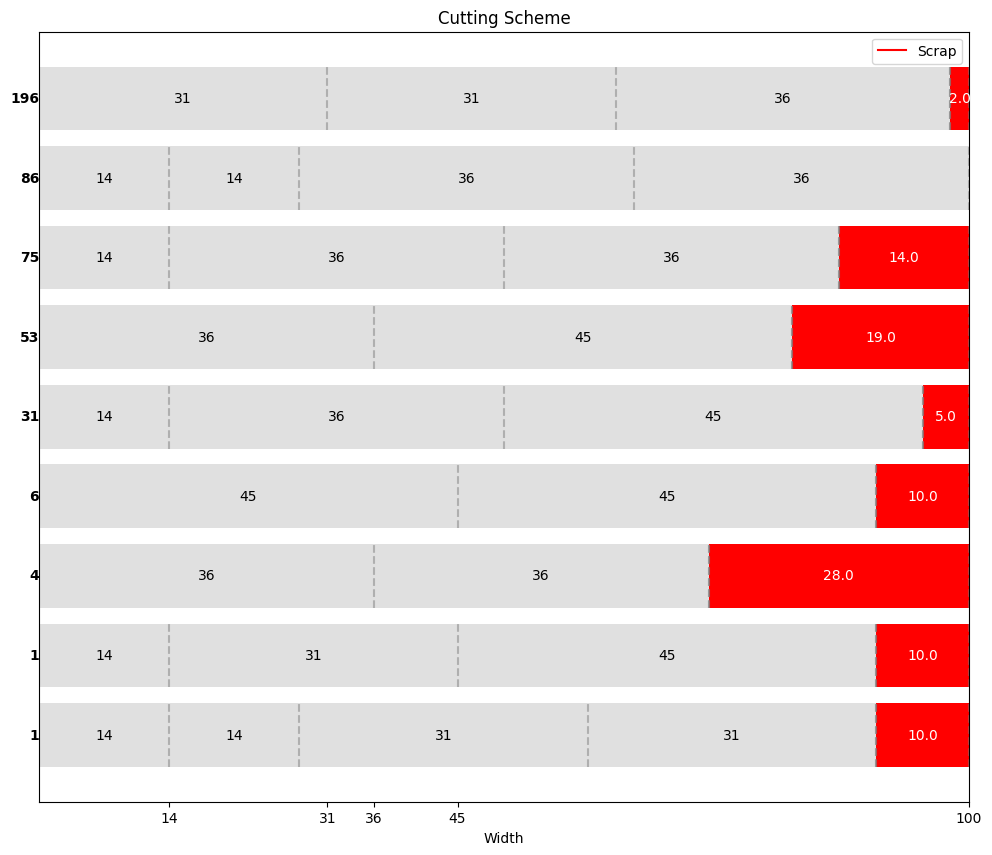

In [7]:
# Generate all possible patterns and coefficients
patterns, aij_values =  generate_patterns(order_widths, roll_width)

# Build an integer variable for each possible patterns
x = {j: Integer(f'x{j}') for j in patterns}

# Initialize CQM
cqm = build_cqm(x, order_widths, patterns, aij_values, demand)

# Instantiate the sampler
sampleset = solve(cqm)

# Parse solution
energy, solution = parse_solution(sampleset)

# Print solution in a human readable diagram
print_solution(solution)